<img src="img/mioti.png" >


# Proyecto Reconocimiento Facial: Modelo VGGFaceCustom

<img src="./img/emociones.png" style="width: 800px">

### Objetivos

* Preparar la estructura de la red neuronal convolucional y entrenarla para que sea capaz de identificar las diferentes emociones clasificadas en el dataset

### Prepación del entorno

In [1]:

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("//content/drive/My Drive/MIOTI/PRY/")

# Check current working directory.
retval = os.getcwd()
print ("Current working directory %s" % retval)

Mounted at /content/drive
Current working directory /content/drive/My Drive/MIOTI/PRY


In [ ]:
#!pip install scikit-plot

### Importación de librerías

* Las librerías que vamos a utilizar en este proceso serán las siguientes:
    * pandas: para trabajar con dataframes
    * numpy: para realizar operaciones aritméticas
    * matplotlib: para la visualización de gráficos de resultados
    * os: para trabajar con directorios
    * json, sys: para la exportación del modelo y los pesos de la red entrenada
    * tensorflow: para la generación de la red neuronal y toda su arquitectura, compilación y entrenamiento
    * sklearn: para la partición de datos, preprocesamiento y análisis de la información

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import json, sys

import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay


### Preprocesing

* En esta parte se va a realizar el tratamiento de los datos para que estos sean compatibles con la red neuronal y el entrenamiento se lleve a cabo de manera satisfactoria. Los pasos que se van a seguir son:
    * Definir forma de las imágenes, tamaño de los lotes en cada paso por época y definir las clases y el número de estas
    * Descarga del dataset y transformación del campo pixels en arrys con el tamaño y forma requerido
    * Partición de los datos primero en entrenamiento y test, después los datos de entrenamiento se volverán a dividir en entrenamiento y validación
    * Transformación de las clases en one hot encoding
    * Normalización de los datos de entrenamiento, validación y test

In [7]:
#Definimos las rutas de los archivos, tamaños de imágenes, lotes y clases
IMG_SIZE = (48,48)#(224,224)
BATCH_SIZE = 64
CLASSES=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
NUM_CLASSES = len(CLASSES)

In [9]:
df = pd.read_csv('./data/fer2013.csv')
# emotion_label = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
INTERESTED_LABELS = [0,1,2,3,4,5,6]
df = df[df.emotion.isin(INTERESTED_LABELS)]

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_labels = df.emotion

X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)



le = LabelEncoder()
img_labels = le.fit_transform(y_train)
img_labels = utils.to_categorical(img_labels)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))


X_train, X_valid, y_train, y_valid = train_test_split(X_train, img_labels ,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)


img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]


#Normalize data
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

In [13]:
le_name_mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

### Model

* En este paso se genera la red que vamos a generar, su arquitectura será la siguiente:
    * Una red de tipo secuencial dividida en 4 partes:
        * Las 3 primeras partes están compuestas por capas convolucionales que recogerán las características de las imágenes, capas de normalización, reducción y Dropout para evitar sobre-ajustes
        * En la última parte se pasa a aplanar los resultados obtenidos para introducirlos después en una red densa que devolverá las probabilidades de que una imagen forme parte de alguna de las diferentes clases
    * Compilación del modelo con una función de pérdida de entropía cruzada categorizada y optimizador Adam
    * Se van a aplicar unas funciones de reducción del learning rate en caso que la función de pérdida quede estancada y de parada del entrenamiento en cuanto se alcancen unos valores de validación satisfactorios
    * Entrenamiento del modelo

In [14]:
batch_size = 32
epochs = 100
def build_model():

    model = Sequential(name='CNN_Face_Emotions')
    ''' First model '''
    model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(img_width, img_height, img_depth),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    ''' Second layer '''
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    ''' Extra layer '''
    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    ''' Third layer '''
    model.add(Flatten())
    model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes,activation='softmax'))

    return model

In [15]:
''' Initialize model '''
model= None
model = build_model()
model.summary()

Model: "CNN_Face_Emotions"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                 

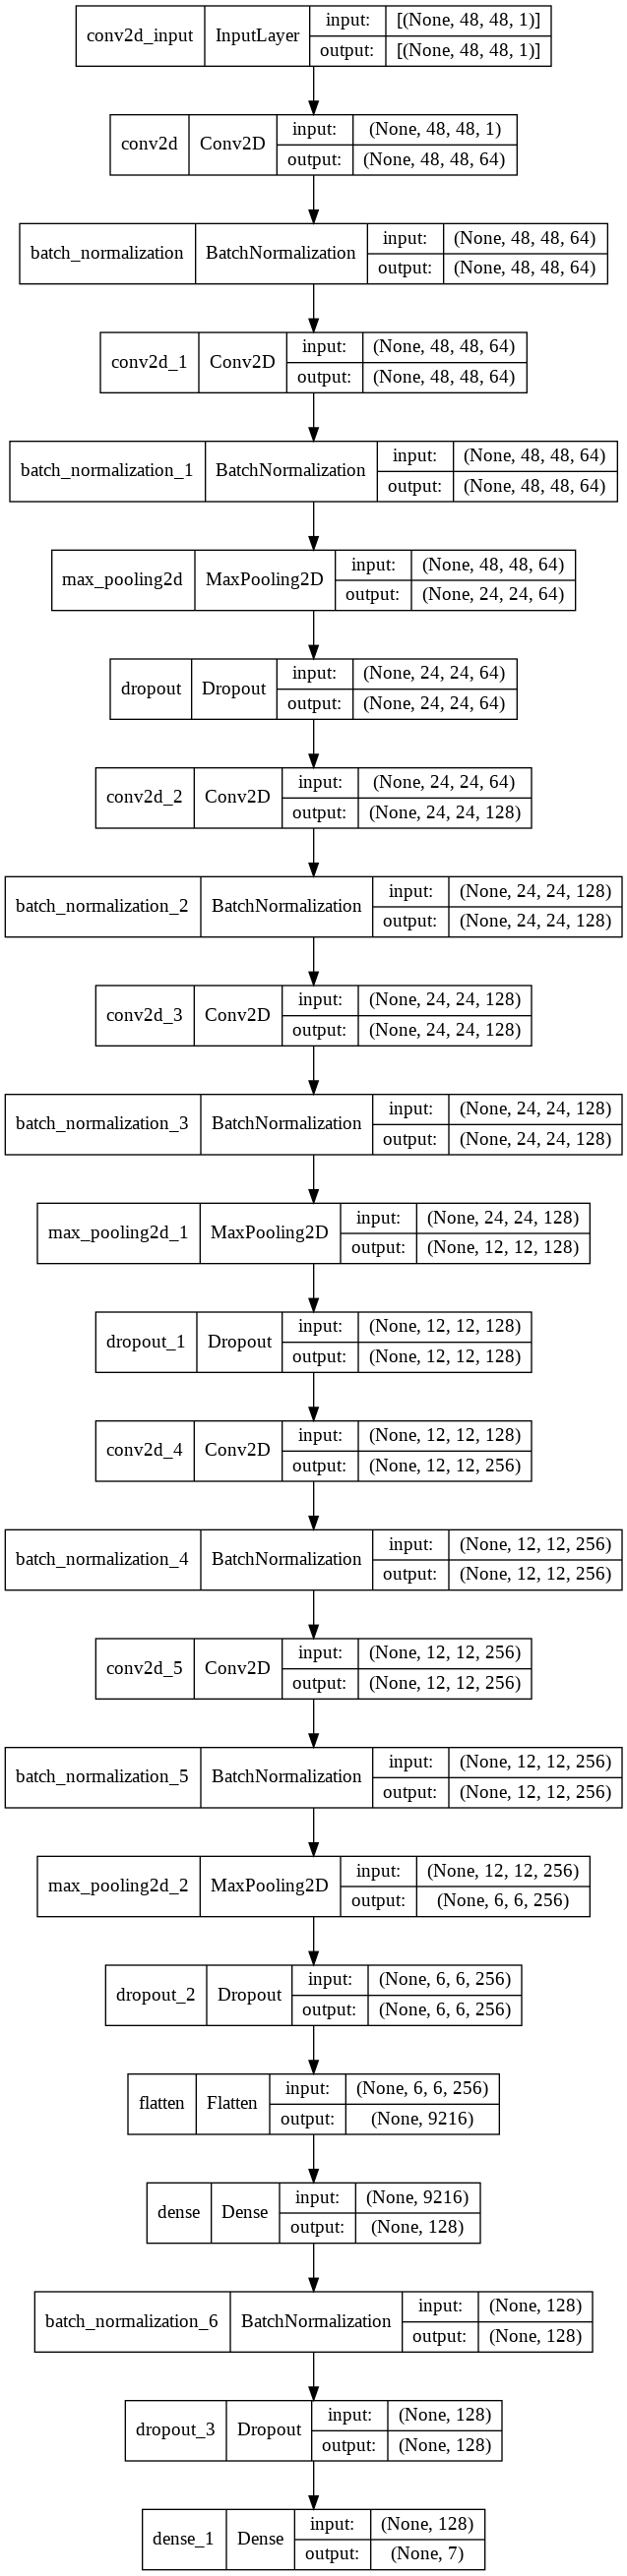

In [16]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

In [ ]:
''' Callbacks '''
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:
import datetime
# Load the TensorBoard notebook extension
%load_ext tensorboard

%rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir logs/fit

In [ ]:
callbacks = [
    ModelCheckpoint('model/vgg-face-v4.h5',save_best_only=False,verbose=0),
    early_stopping,
    lr_scheduler,
    tensorboard_callback
]

In [ ]:
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     shear_range=0.15,
#     zoom_range=0.15,
#     horizontal_flip=True,
# )
# train_datagen.fit(X_train)

In [ ]:
''' Train model '''
history=model.fit(X_train, y_train,
          callbacks=callbacks,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, y_valid),
          shuffle=True)


# train_datagen.flow(X_train, y_train, batch_size=batch_size),
# validation_data=(X_valid, y_valid),

''' Saving the  model to  use it later on'''
fer_json = model.to_json()
with open("model/vgg-face-model-v4.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("model/vgg-face-v4.h5")

Epoch 1/100
909/909 [==============================] - 71s 66ms/step - loss: 1.7474 - accuracy: 0.3429 - val_loss: 1.4320 - val_accuracy: 0.4582 - lr: 0.0010
Epoch 2/100
909/909 [==============================] - 59s 65ms/step - loss: 1.4110 - accuracy: 0.4559 - val_loss: 1.2883 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 3/100
909/909 [==============================] - 59s 65ms/step - loss: 1.2868 - accuracy: 0.5117 - val_loss: 1.1989 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 4/100
909/909 [==============================] - 59s 65ms/step - loss: 1.2004 - accuracy: 0.5470 - val_loss: 1.1187 - val_accuracy: 0.5854 - lr: 0.0010
Epoch 5/100
909/909 [==============================] - 58s 64ms/step - loss: 1.1297 - accuracy: 0.5755 - val_loss: 1.0776 - val_accuracy: 0.5978 - lr: 0.0010
Epoch 6/100
909/909 [==============================] - 58s 64ms/step - loss: 1.0681 - accuracy: 0.6009 - val_loss: 1.1764 - val_accuracy: 0.5619 - lr: 0.0010
Epoch 7/100
909/909 [==============================]

### Análisis de resultados

* A continuación se va a visualizar la evolución del entrenamiento para los conjuntos de entrenamiento y validación tanto para el accuracy como para la pérdida
* Después pasaremos a guardar el modelo y sus pesos en unos archivos para más adelante utilizarlos en el modelo definitivo
* Por último se pasará a realizar la predicción de los datos de test y a dibujar la matriz de confusión para visualizar qué tan bien ha logrado acertar nuestro modelo en las diferentes emociones

In [ ]:
def print_result(my_history,my_dropout=None):

    acc = my_history.history['accuracy']
    val_acc = my_history.history['val_accuracy']

    loss = my_history.history['loss']
    val_loss = my_history.history['val_loss']

    # Extraemos el número de épocas
    epochs = range(len(acc))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14,5))
    # Representamos con plot nuestro accuracy por epoch
    ax1.plot(epochs, acc, label = 'train_acc')
    ax1.plot(epochs, val_acc, label = 'val_acc')
    if (my_dropout):
      title= 'Training and validation accuracy with dropout rate = '+str(my_dropout)
    else:
      title= 'Training and validation accuracy'

    ax1.set_title(title)
    ax1.legend()
    

    # Representamos con plot nuestro loss por epoch
    ax2.plot(epochs, loss, label = 'loss')
    ax2.plot(epochs, val_loss, label = 'val_loss')
    if (my_dropout):
      title= 'Training and validation loss with dropout rate = '+str(my_dropout)
    else:
      title= 'Training and validation loss'

    ax2.set_title(title)
    ax2.legend()
    fig.suptitle('Resultados')
    
    plt.show()
    

    return None

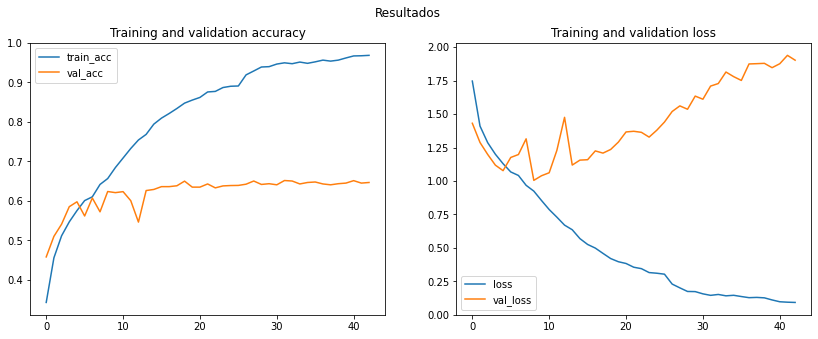

In [ ]:
print_result(history)

In [ ]:
file_model="./model/vgg-face-model-v4.json"
file_weights="./model/vgg-face-v4.h5"

In [ ]:
json_file = open(file_model, 'r')
model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(model_json)
model.load_weights(file_weights)

In [ ]:
model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

In [ ]:
test_prob = model.predict(X_test)
y_test_pred = np.argmax(test_prob, axis=1)

In [ ]:
conf_mat = confusion_matrix(np.array(y_test), y_test_pred)
pd.DataFrame(conf_mat, columns=CLASSES, index=CLASSES)


,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
Angry,279,1,48,24,74,19,50
Disgust,7,26,10,2,5,3,2
Fear,64,1,249,21,78,56,43
Happy,21,0,20,764,27,23,44
Sad,64,1,81,31,337,9,85
Surprise,13,1,22,21,9,325,9
Neutral,41,1,39,52,79,19,389


In [ ]:
print(classification_report(y_test, y_test_pred, target_names=CLASSES))

              precision    recall  f1-score   support

       Angry       0.57      0.56      0.57       495
     Disgust       0.84      0.47      0.60        55
        Fear       0.53      0.49      0.51       512
       Happy       0.83      0.85      0.84       899
         Sad       0.55      0.55      0.55       608
    Surprise       0.72      0.81      0.76       400
     Neutral       0.63      0.63      0.63       620

    accuracy                           0.66      3589
   macro avg       0.67      0.62      0.64      3589
weighted avg       0.66      0.66      0.66      3589



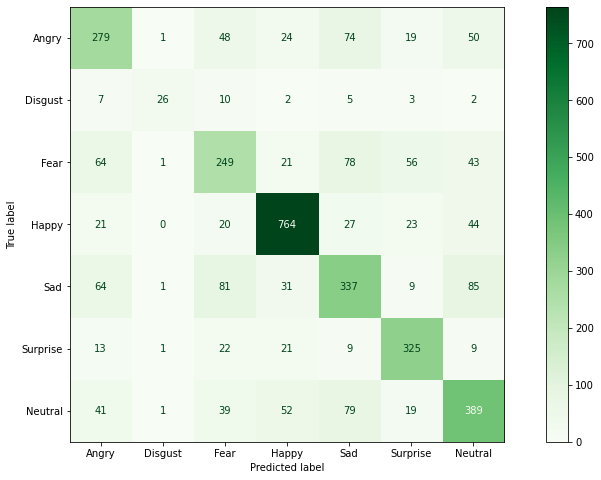

In [ ]:
# Sacamos la matriz de confusión
y_predicted = model.predict(X_test)
y_predicted = np.argmax(y_predicted, axis=1)

fig, ax = plt.subplots(figsize=(15, 8))
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=CLASSES)
cmd.plot(ax=ax,cmap='Greens');
